# Используемые библиотеки

In [83]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd

from geopy.distance import distance
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import make_scorer, mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [5]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [6]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [7]:
def corelate_df(df, minimal):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.4)

    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) <= minimal] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()

# Загрузка данных

In [8]:
df = pd.read_csv('data\data_set_to_train.csv')

X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]
X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

X_final = pd.read_csv('data\data_set_to_test_X.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 13828
Строк в тесте 6812


In [9]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [10]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [11]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [188]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [189]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           13828 non-null  float32 
 1   latitude            13828 non-null  float32 
 2   housing_median_age  13349 non-null  float32 
 3   total_rooms         13828 non-null  float32 
 4   total_bedrooms      13828 non-null  float32 
 5   population          13429 non-null  float32 
 6   households          13828 non-null  float32 
 7   median_income       13828 non-null  float32 
 8   ocean_proximity     13828 non-null  category
dtypes: category(1), float32(8)
memory usage: 553.9 KB


In [102]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [103]:
X.shape

(13828, 9)

In [104]:
X[['longitude', 'latitude']].head(5)

,longitude,latitude
Id,,
5088,-118.279999,33.980000
17096,-122.230003,37.459999
5617,-118.260002,33.790001
20060,-119.260002,35.869999
895,-121.959999,37.540001


## Переменные

In [105]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.569706,2647.572998,540.267151,1430.852661,501.675446,3.876735
std,4.857742,115.936920,12.583060,2171.663818,421.248840,1148.826538,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


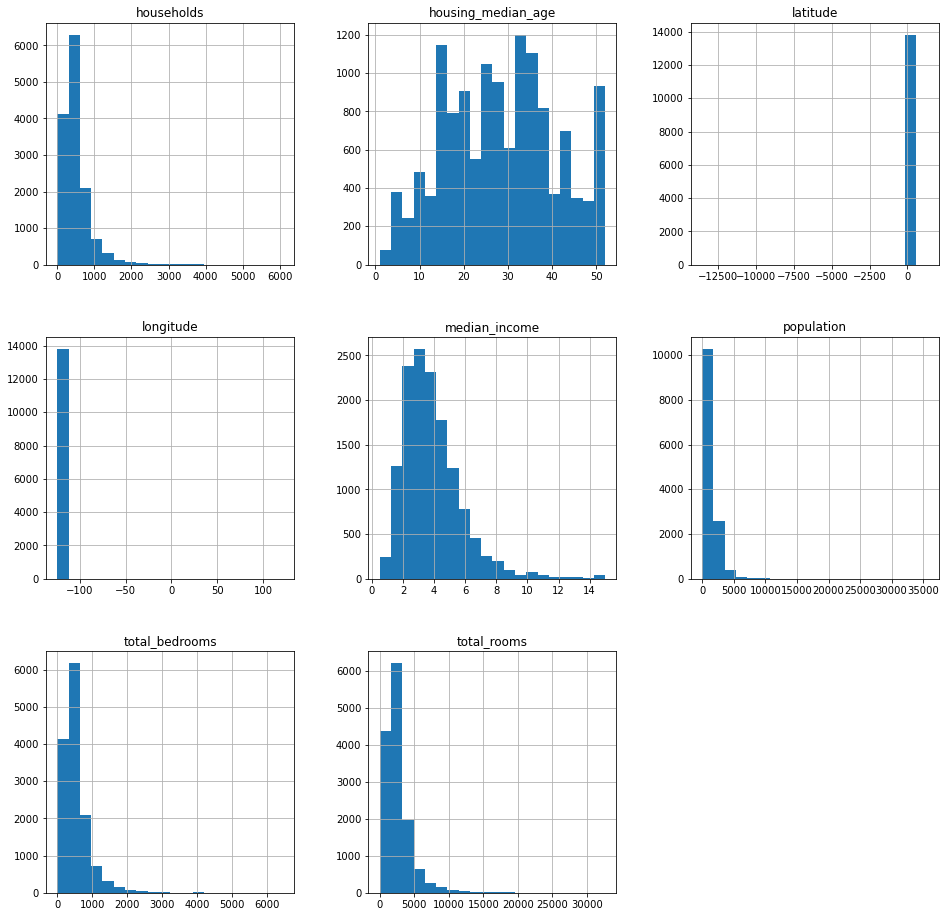

In [16]:
X.hist(figsize=(16,16), bins=20);

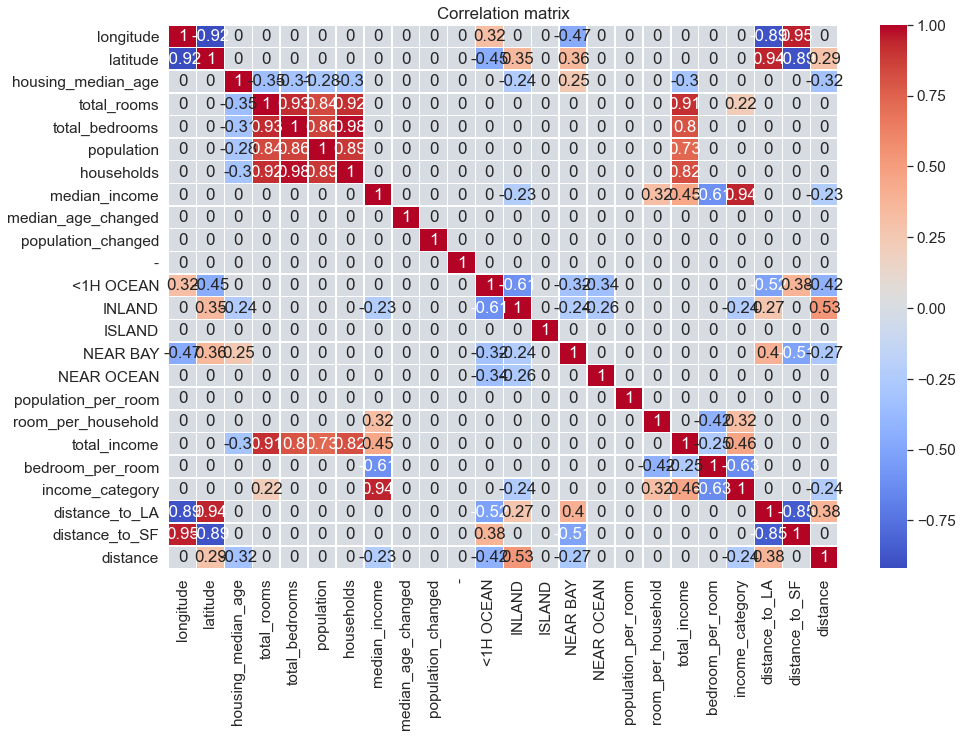

In [103]:
corelate_df(X, 0.2)

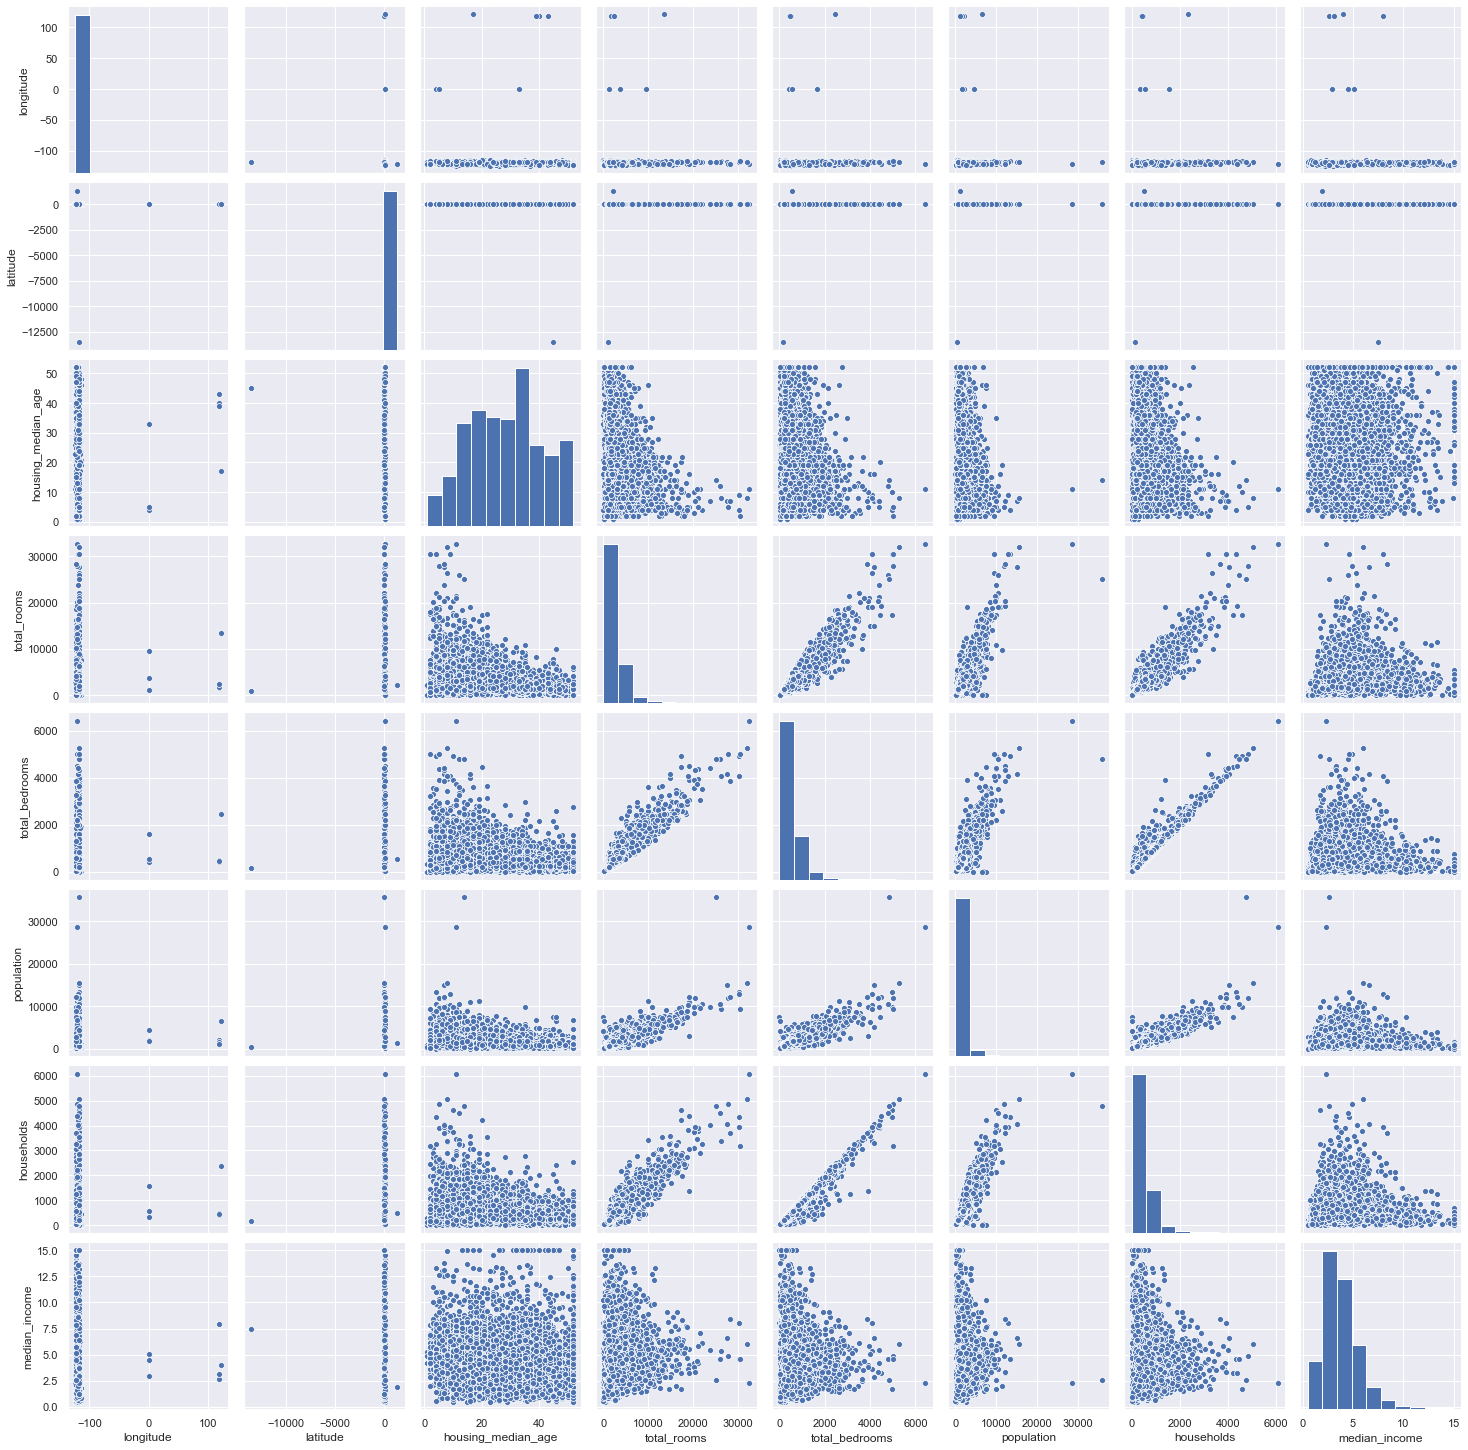

In [18]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

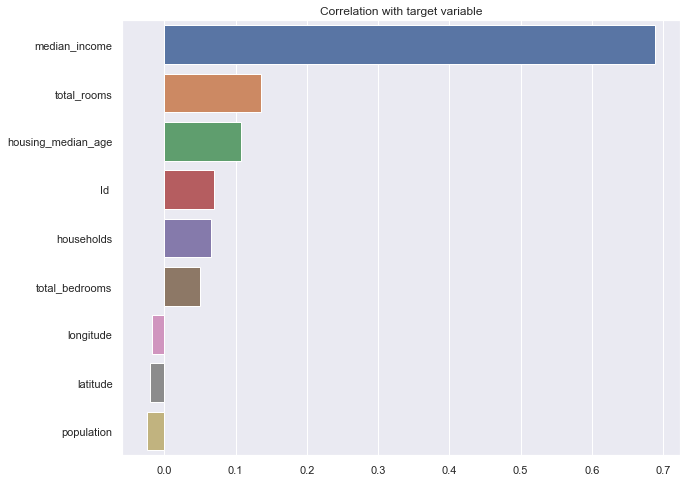

In [19]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [20]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

# Исправляем и дополняем

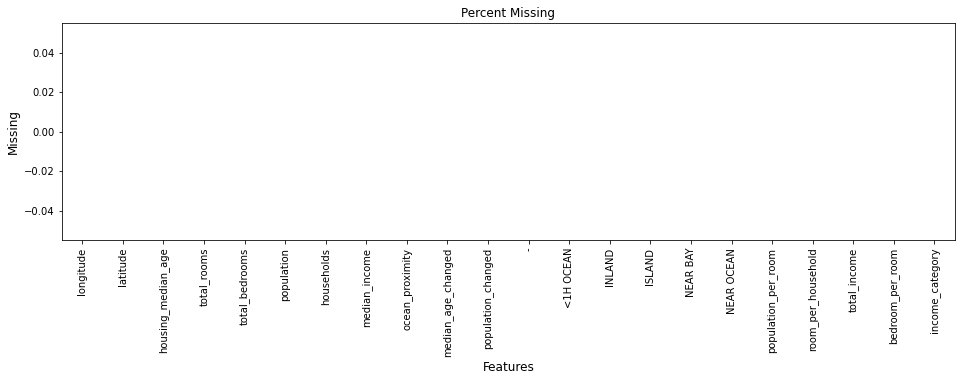

In [51]:
nan_analize(X)

In [12]:
X['median_age_changed'] = 0
X_final['median_age_changed'] = 0

X.loc[X.isna()['housing_median_age'] == True, 'median_age_changed'] = 1
X_final.loc[X_final.isna()['housing_median_age'] == True, 'median_age_changed'] = 1

median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
median = X_final['housing_median_age'].median()
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [13]:
X['population_changed'] = 0
X_final['population_changed'] = 0

X.loc[X.isna()['population'] == True, 'population_changed'] = 1
X_final.loc[X_final.isna()['population'] == True, 'population_changed'] = 1

median = X['population'].median()
X['population'] = X['population'].fillna(median)
median = X_final['population'].median()
X_final['population'] = X_final['population'].fillna(median)

In [14]:
median = X['total_bedrooms'].median()
X['total_bedrooms'] = X['total_bedrooms'].fillna(median)
median = X_final['total_bedrooms'].median()
X_final['total_bedrooms'] = X_final['total_bedrooms'].fillna(median)

In [15]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [16]:
X.loc[8283, 'latitude'] = 33.700000
X.loc[12772, 'latitude'] = 40.600000

X.loc[19423, 'longitude'] = -121.600000
X.loc[17085, 'longitude'] = -121.900000
X.loc[17359, 'longitude'] = -118.500000

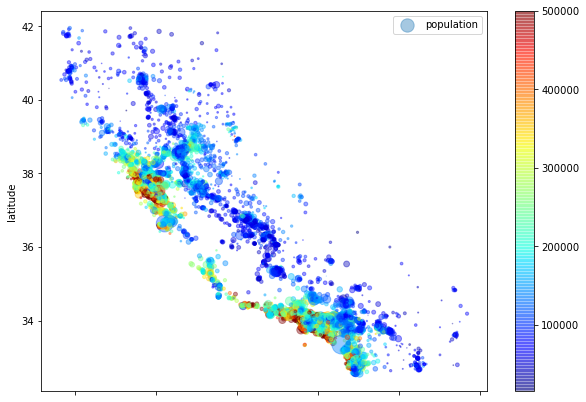

In [17]:
X.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X['population']/100, label='population', figsize=(10,7), 
    c=y['median_house_value'], cmap=plt.get_cmap('jet'), colorbar=True)

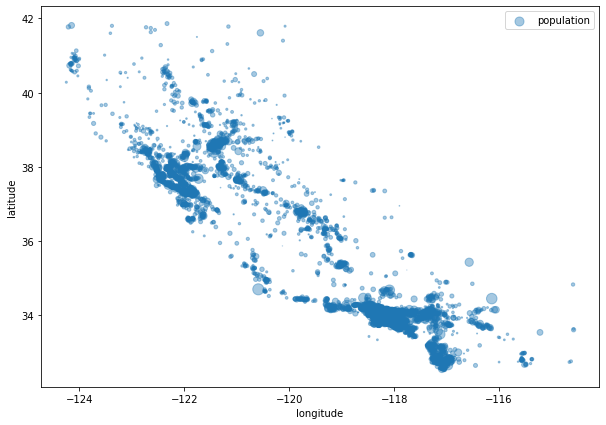

In [18]:
X_final.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X_final['population']/100, label='population', figsize=(10,7))

In [19]:
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [20]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [21]:
X['room_per_household'] = X['total_rooms'] / X['households']
X_final['room_per_household'] = X_final['total_rooms'] / X_final['households']

In [22]:
X['total_income'] = X['households'] * X['median_income']
X_final['total_income'] = X_final['households'] * X_final['median_income']

In [23]:
X.loc[X['total_bedrooms'] >= X['total_rooms'] ].head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_age_changed,population_changed,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income
Id,,,,,,,,,,,,,,,,,,,,
3126,-117.790001,35.209999,4.0,2.0,2.0,6.0,2.0,2.375,INLAND,0,0,0,0,1,0,0,0,3.000000,1.000000,4.750
19435,-121.040001,37.669998,16.0,19.0,19.0,166.0,9.0,0.536,INLAND,0,0,0,0,1,0,0,0,8.736842,2.111111,4.824


In [24]:
X['bedroom_per_room'] = X['total_bedrooms'] / X['total_rooms']
X_final['bedroom_per_room'] = X_final['total_bedrooms'] / X_final['total_rooms']

In [25]:
X['income_category'] = np.ceil(X['median_income'])
X_final['income_category'] = np.ceil(X_final['median_income'])

In [26]:
for i in range(1, 17):
    print(i, len(X.loc[X['income_category'] == i]), len(X_final.loc[X_final['income_category'] == i]))

1 104 55
2 1544 754
3 3290 1656
4 3439 1711
5 2433 1165
6 1436 691
7 772 391
8 348 161
9 194 89
10 67 32
11 99 51
12 24 21
13 21 13
14 14 8
15 6 2
16 37 12


In [27]:
X.loc[X['income_category'] == 2, 'income_category'] = 1
X.loc[X['income_category'] == 3, 'income_category'] = 2
X.loc[X['income_category'] == 4, 'income_category'] = 3
X.loc[X['income_category'] == 5, 'income_category'] = 4
X.loc[X['income_category'] == 6, 'income_category'] = 5
X.loc[X['income_category'] == 7, 'income_category'] = 6
X.loc[X['income_category'] == 8, 'income_category'] = 6
X.loc[X['income_category'] > 8, 'income_category'] = 7

X_final.loc[X_final['income_category'] == 2, 'income_category'] = 1
X_final.loc[X_final['income_category'] == 3, 'income_category'] = 2
X_final.loc[X_final['income_category'] == 4, 'income_category'] = 3
X_final.loc[X_final['income_category'] == 5, 'income_category'] = 4
X_final.loc[X_final['income_category'] == 6, 'income_category'] = 5
X_final.loc[X_final['income_category'] == 7, 'income_category'] = 6
X_final.loc[X_final['income_category'] == 8, 'income_category'] = 6
X_final.loc[X_final['income_category'] > 8, 'income_category'] = 7

In [28]:
LA_coords = (34.055855, -118.246130)
SF_coords = (37.759351, -122.446904)

X['distance_to_LA'] = X.apply(lambda row: distance((row['latitude'], row['longitude']), LA_coords).km, axis = 1)
X['distance_to_SF'] = X.apply(lambda row: distance((row['latitude'], row['longitude']), SF_coords).km, axis = 1)
X_final['distance_to_LA'] = X_final.apply(lambda row: distance((row['latitude'], row['longitude']), LA_coords).km, axis = 1)
X_final['distance_to_SF'] = X_final.apply(lambda row: distance((row['latitude'], row['longitude']), SF_coords).km, axis = 1)

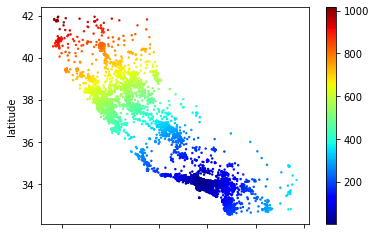

In [29]:
X.plot(kind='scatter', x='longitude', y='latitude', s=2,
    c=X['distance_to_LA'], cmap=plt.get_cmap('jet'), colorbar=True)

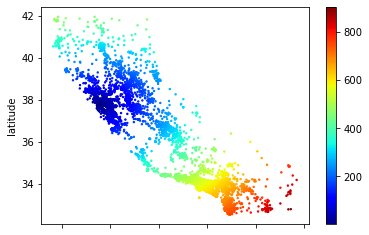

In [30]:
X.plot(kind='scatter', x='longitude', y='latitude', s=2,
    c=X['distance_to_SF'], cmap=plt.get_cmap('jet'), colorbar=True)

In [31]:
X['distance'] = X.apply(lambda row: min(row['distance_to_LA'], row['distance_to_SF']), axis = 1)
X_final['distance'] = X_final.apply(lambda row: min(row['distance_to_LA'], row['distance_to_SF']), axis = 1)

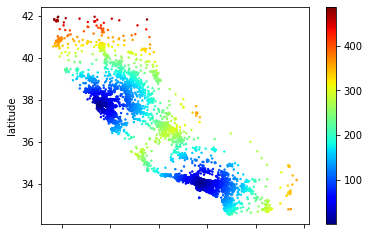

In [32]:
X.plot(kind='scatter', x='longitude', y='latitude', s=2,
    c=X['distance'], cmap=plt.get_cmap('jet'), colorbar=True)

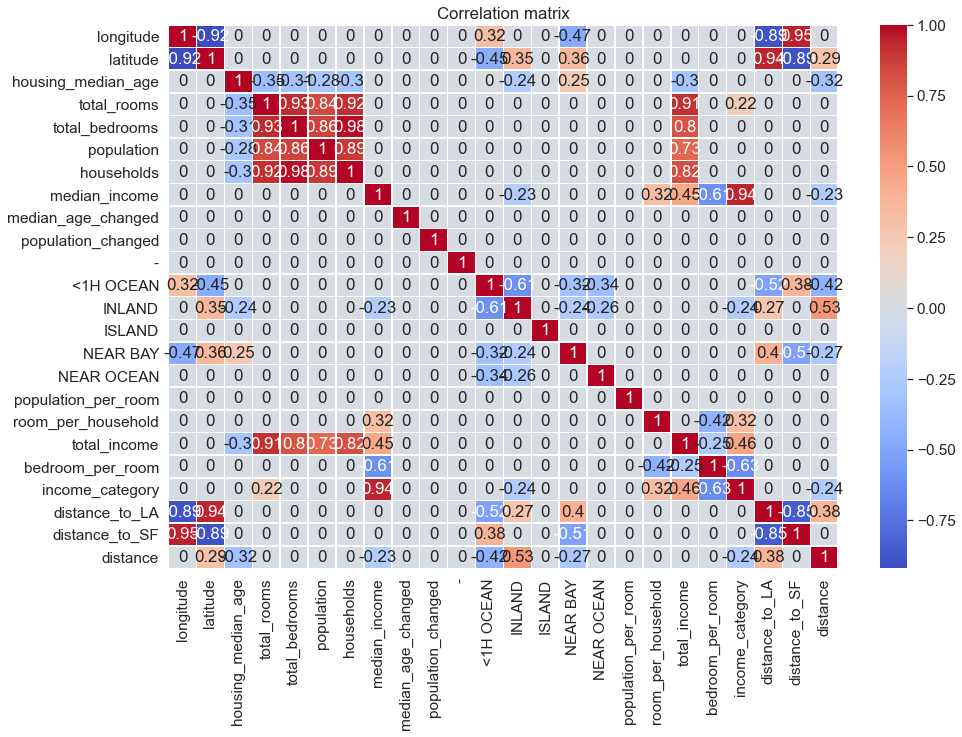

In [33]:
corelate_df(X, 0.2)

In [34]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_age_changed,population_changed,...,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category,distance_to_LA,distance_to_SF,distance
count,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,...,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000
mean,-119.584946,35.651432,28.584610,2647.572998,540.267151,1423.267578,501.675446,3.876735,0.034640,0.028854,...,0.112236,0.123084,0.637027,5.436546,1952.576416,0.213001,3.283989,270.622398,384.751644,90.346886
std,2.005138,2.134328,12.363278,2171.663818,421.248840,1132.986938,383.638641,1.903102,0.182873,0.167404,...,0.315668,0.328545,3.532465,2.449446,1906.061523,0.058328,1.577628,247.857967,249.439013,84.739860
min,-124.349998,32.549999,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,...,0.000000,0.000000,0.019218,0.888889,1.608000,0.100000,1.000000,0.582399,0.281856,0.281856
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,801.000000,280.000000,2.568575,0.000000,0.000000,...,0.000000,0.000000,0.433649,4.459802,870.871826,0.175255,2.000000,32.499996,117.800862,23.297638
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750,0.000000,0.000000,...,0.000000,0.000000,0.516548,5.232422,1463.781006,0.202996,3.000000,174.266151,524.540595,58.552606
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1710.000000,607.000000,4.756600,0.000000,0.000000,...,0.000000,0.000000,0.658146,6.058565,2403.553894,0.239353,4.000000,527.689949,583.654328,140.459741
max,-114.309998,41.950001,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000,...,1.000000,1.000000,392.631592,141.909088,31501.853516,1.000000,7.000000,1017.076091,904.326593,487.301412


In [35]:
X_final.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_age_changed,population_changed,...,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category,distance_to_LA,distance_to_SF,distance
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,...,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000
mean,-119.538300,35.592514,28.830446,2611.800293,529.727661,1406.821045,495.204193,3.858350,0.035672,0.029360,...,0.108045,0.139900,0.604593,5.413654,1923.620850,0.215302,3.270258,266.246557,391.436266,90.792594
std,2.000073,2.139396,12.337366,2201.645996,415.576874,1091.458130,379.648621,1.893224,0.185486,0.168826,...,0.310460,0.346909,0.571533,2.523734,1893.785400,0.076911,1.577052,246.221758,249.916316,84.447670
min,-124.250000,32.540001,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,0.000000,0.000000,...,0.000000,0.000000,0.018109,0.846154,2.999400,0.036724,1.000000,0.729411,0.281856,0.281856
25%,-121.760002,33.919998,19.000000,1434.000000,298.000000,786.750000,279.000000,2.550775,0.000000,0.000000,...,0.000000,0.000000,0.435523,4.409941,850.110611,0.175096,2.000000,31.862876,122.155800,23.396660
50%,-118.480003,34.230000,29.000000,2106.000000,430.000000,1157.000000,406.000000,3.527800,0.000000,0.000000,...,0.000000,0.000000,0.515201,5.224030,1453.958069,0.203509,3.000000,173.351455,528.974482,58.598775
75%,-117.989998,37.709999,37.000000,3109.250000,631.000000,1689.000000,598.000000,4.733225,0.000000,0.000000,...,0.000000,0.000000,0.660210,6.040538,2352.117737,0.241587,4.000000,522.835072,585.590713,142.858542
max,-114.580002,41.860001,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,1.000000,1.000000,...,1.000000,1.000000,32.138889,132.533340,38890.000000,2.792208,7.000000,1004.438135,901.425244,491.267771


In [36]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_age_changed', 'population_changed', '-',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN',
       'population_per_room', 'room_per_household', 'total_income',
       'bedroom_per_room', 'income_category', 'distance_to_LA',
       'distance_to_SF', 'distance'],
      dtype='object')

# Проверяем модель

In [ ]:
#0.82598  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
#0.83272  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room',
#0.83306  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed']
#0.83321  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed']
#0.83374  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category']
#0.83500  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room']
#0.83558  max_depth=16, n_estimators=325
#0.83582  max_depth=17, n_estimators=300, num_leaves=32
#0.83637  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room', 'distance']
#0.83659  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room', 'distance']
#0.83946  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room', 'distance']
#0.83989  ['longitude', 'latitude', 'housing_median_age', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room', 'distance']
#0.8417   (max_depth=15, n_estimators=295, num_leaves=30, random_state=42)

In [37]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'median_income', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_room', 'median_age_changed', 'population_changed', 'income_category', 'bedroom_per_room', 'distance']

X1 = X[remain_features]
X1_final = X_final[remain_features]

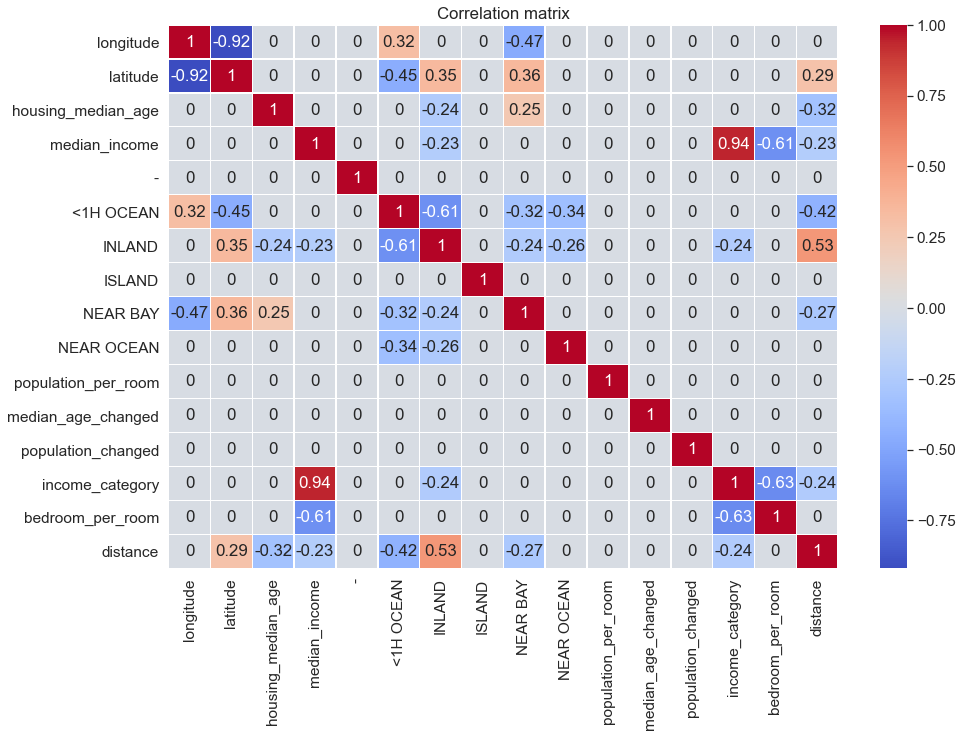

In [38]:
corelate_df(X1, 0.2)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

In [98]:
maximum = 0
maxi = 0
maxk = 0
maxm = 0
summary = len(range(10, 21, 1)) * len(range(250, 351, 5)) * len(range(25, 36, 1))
count = 0

for i in range(10, 21, 1):
    for k in range(250, 351, 5):
        for m in range(25, 36, 1):
            model = LGBMRegressor(max_depth=i,
                     n_estimators=k, num_leaves=m,
                     random_state=42)
            model.fit(X_train, y_train)

            y_pred_test = model.predict(X_test)
            for j in range(len(y_pred_test)):
                if y_pred_test[j] > 500000:
                    y_pred_test[j] = 500001

            score = r2(y_test['median_house_value'], y_pred_test)
            count += 1
            print(f"\ni: {i}   k: {k}   m: {m}   score: {round(score, 4)}    {round(count * 100 / summary, 2)} %", end="   ")
            if score > maximum:
                if maximum != 0:
                    print(f"maximum: {round(score, 4)}", end="   ")
                maximum = score
                maxi = i
                maxk = k
                maxm = m
print("Results:")
print(f"model = LGBMRegressor(max_depth={maxi}, n_estimators={maxk}, num_leaves={maxm}, random_state=42)")
print(f"score: {maximum}")


i: 10   k: 250   m: 25   score: 0.8373    0.02 %   
i: 10   k: 250   m: 26   score: 0.8371    0.03 %   
i: 10   k: 250   m: 27   score: 0.8384    0.05 %   maximum: 0.8384   
i: 10   k: 250   m: 28   score: 0.8393    0.06 %   maximum: 0.8393   
i: 10   k: 250   m: 29   score: 0.8388    0.08 %   
i: 10   k: 250   m: 30   score: 0.8376    0.1 %   
i: 10   k: 250   m: 31   score: 0.8374    0.11 %   
i: 10   k: 250   m: 32   score: 0.8399    0.13 %   maximum: 0.8399   
i: 10   k: 250   m: 33   score: 0.8387    0.15 %   
i: 10   k: 250   m: 34   score: 0.8374    0.16 %   
i: 10   k: 250   m: 35   score: 0.8396    0.18 %   
i: 10   k: 252   m: 25   score: 0.8374    0.19 %   
i: 10   k: 252   m: 26   score: 0.8371    0.21 %   
i: 10   k: 252   m: 27   score: 0.8386    0.23 %   
i: 10   k: 252   m: 28   score: 0.8393    0.24 %   
i: 10   k: 252   m: 29   score: 0.8388    0.26 %   
i: 10   k: 252   m: 30   score: 0.8377    0.28 %   
i: 10   k: 252   m: 31   score: 0.8373    0.29 %   
i: 10   k:

i: 10   k: 306   m: 26   score: 0.8377    5.02 %   
i: 10   k: 306   m: 27   score: 0.8392    5.04 %   
i: 10   k: 306   m: 28   score: 0.8398    5.06 %   
i: 10   k: 306   m: 29   score: 0.8396    5.07 %   
i: 10   k: 306   m: 30   score: 0.8386    5.09 %   
i: 10   k: 306   m: 31   score: 0.8385    5.1 %   
i: 10   k: 306   m: 32   score: 0.8401    5.12 %   
i: 10   k: 306   m: 33   score: 0.8393    5.14 %   
i: 10   k: 306   m: 34   score: 0.8383    5.15 %   
i: 10   k: 306   m: 35   score: 0.84    5.17 %   
i: 10   k: 308   m: 25   score: 0.8381    5.19 %   
i: 10   k: 308   m: 26   score: 0.838    5.2 %   
i: 10   k: 308   m: 27   score: 0.8392    5.22 %   
i: 10   k: 308   m: 28   score: 0.8399    5.23 %   
i: 10   k: 308   m: 29   score: 0.8396    5.25 %   
i: 10   k: 308   m: 30   score: 0.8385    5.27 %   
i: 10   k: 308   m: 31   score: 0.8386    5.28 %   
i: 10   k: 308   m: 32   score: 0.8401    5.3 %   
i: 10   k: 308   m: 33   score: 0.8394    5.32 %   
i: 10   k: 308   m

i: 11   k: 260   m: 33   score: 0.8381    10.13 %   
i: 11   k: 260   m: 34   score: 0.8387    10.14 %   
i: 11   k: 260   m: 35   score: 0.8394    10.16 %   
i: 11   k: 262   m: 25   score: 0.837    10.18 %   
i: 11   k: 262   m: 26   score: 0.8382    10.19 %   
i: 11   k: 262   m: 27   score: 0.8374    10.21 %   
i: 11   k: 262   m: 28   score: 0.8383    10.23 %   
i: 11   k: 262   m: 29   score: 0.8385    10.24 %   
i: 11   k: 262   m: 30   score: 0.8399    10.26 %   
i: 11   k: 262   m: 31   score: 0.8385    10.27 %   
i: 11   k: 262   m: 32   score: 0.8387    10.29 %   
i: 11   k: 262   m: 33   score: 0.8381    10.31 %   
i: 11   k: 262   m: 34   score: 0.8386    10.32 %   
i: 11   k: 262   m: 35   score: 0.8393    10.34 %   
i: 11   k: 264   m: 25   score: 0.8371    10.35 %   
i: 11   k: 264   m: 26   score: 0.8383    10.37 %   
i: 11   k: 264   m: 27   score: 0.8375    10.39 %   
i: 11   k: 264   m: 28   score: 0.8383    10.4 %   
i: 11   k: 264   m: 29   score: 0.8385    10.42 

i: 11   k: 316   m: 30   score: 0.8411    15.07 %   maximum: 0.8411   
i: 11   k: 316   m: 31   score: 0.8392    15.09 %   
i: 11   k: 316   m: 32   score: 0.8399    15.1 %   
i: 11   k: 316   m: 33   score: 0.8386    15.12 %   
i: 11   k: 316   m: 34   score: 0.8395    15.14 %   
i: 11   k: 316   m: 35   score: 0.8394    15.15 %   
i: 11   k: 318   m: 25   score: 0.8385    15.17 %   
i: 11   k: 318   m: 26   score: 0.8383    15.18 %   
i: 11   k: 318   m: 27   score: 0.8386    15.2 %   
i: 11   k: 318   m: 28   score: 0.839    15.22 %   
i: 11   k: 318   m: 29   score: 0.8393    15.23 %   
i: 11   k: 318   m: 30   score: 0.841    15.25 %   
i: 11   k: 318   m: 31   score: 0.8392    15.26 %   
i: 11   k: 318   m: 32   score: 0.8398    15.28 %   
i: 11   k: 318   m: 33   score: 0.8386    15.3 %   
i: 11   k: 318   m: 34   score: 0.8394    15.31 %   
i: 11   k: 318   m: 35   score: 0.8394    15.33 %   
i: 11   k: 320   m: 25   score: 0.8385    15.35 %   
i: 11   k: 320   m: 26   score: 0

i: 12   k: 270   m: 29   score: 0.8391    20.05 %   
i: 12   k: 270   m: 30   score: 0.8376    20.06 %   
i: 12   k: 270   m: 31   score: 0.8405    20.08 %   
i: 12   k: 270   m: 32   score: 0.8403    20.09 %   
i: 12   k: 270   m: 33   score: 0.8398    20.11 %   
i: 12   k: 270   m: 34   score: 0.8386    20.13 %   
i: 12   k: 270   m: 35   score: 0.8396    20.14 %   
i: 12   k: 272   m: 25   score: 0.8369    20.16 %   
i: 12   k: 272   m: 26   score: 0.8395    20.18 %   
i: 12   k: 272   m: 27   score: 0.8383    20.19 %   
i: 12   k: 272   m: 28   score: 0.8394    20.21 %   
i: 12   k: 272   m: 29   score: 0.839    20.22 %   
i: 12   k: 272   m: 30   score: 0.8376    20.24 %   
i: 12   k: 272   m: 31   score: 0.8404    20.26 %   
i: 12   k: 272   m: 32   score: 0.8403    20.27 %   
i: 12   k: 272   m: 33   score: 0.8399    20.29 %   
i: 12   k: 272   m: 34   score: 0.8384    20.3 %   
i: 12   k: 272   m: 35   score: 0.8397    20.32 %   
i: 12   k: 274   m: 25   score: 0.8369    20.34 

i: 12   k: 326   m: 31   score: 0.8405    25.07 %   
i: 12   k: 326   m: 32   score: 0.8404    25.09 %   
i: 12   k: 326   m: 33   score: 0.84    25.1 %   
i: 12   k: 326   m: 34   score: 0.8387    25.12 %   
i: 12   k: 326   m: 35   score: 0.8403    25.13 %   
i: 12   k: 328   m: 25   score: 0.8371    25.15 %   
i: 12   k: 328   m: 26   score: 0.84    25.17 %   
i: 12   k: 328   m: 27   score: 0.8391    25.18 %   
i: 12   k: 328   m: 28   score: 0.8402    25.2 %   
i: 12   k: 328   m: 29   score: 0.8397    25.21 %   
i: 12   k: 328   m: 30   score: 0.838    25.23 %   
i: 12   k: 328   m: 31   score: 0.8405    25.25 %   
i: 12   k: 328   m: 32   score: 0.8404    25.26 %   
i: 12   k: 328   m: 33   score: 0.8401    25.28 %   
i: 12   k: 328   m: 34   score: 0.8387    25.3 %   
i: 12   k: 328   m: 35   score: 0.8402    25.31 %   
i: 12   k: 330   m: 25   score: 0.8371    25.33 %   
i: 12   k: 330   m: 26   score: 0.8401    25.34 %   
i: 12   k: 330   m: 27   score: 0.839    25.36 %   
i:

i: 13   k: 280   m: 33   score: 0.8397    30.09 %   
i: 13   k: 280   m: 34   score: 0.8383    30.11 %   
i: 13   k: 280   m: 35   score: 0.8374    30.12 %   
i: 13   k: 282   m: 25   score: 0.8377    30.14 %   
i: 13   k: 282   m: 26   score: 0.8373    30.16 %   
i: 13   k: 282   m: 27   score: 0.8403    30.17 %   
i: 13   k: 282   m: 28   score: 0.8396    30.19 %   
i: 13   k: 282   m: 29   score: 0.8398    30.21 %   
i: 13   k: 282   m: 30   score: 0.8387    30.22 %   
i: 13   k: 282   m: 31   score: 0.8413    30.24 %   
i: 13   k: 282   m: 32   score: 0.8402    30.25 %   
i: 13   k: 282   m: 33   score: 0.8396    30.27 %   
i: 13   k: 282   m: 34   score: 0.8383    30.29 %   
i: 13   k: 282   m: 35   score: 0.8376    30.3 %   
i: 13   k: 284   m: 25   score: 0.8376    30.32 %   
i: 13   k: 284   m: 26   score: 0.8374    30.34 %   
i: 13   k: 284   m: 27   score: 0.8403    30.35 %   
i: 13   k: 284   m: 28   score: 0.8396    30.37 %   
i: 13   k: 284   m: 29   score: 0.8398    30.38

i: 13   k: 336   m: 35   score: 0.8374    35.12 %   
i: 13   k: 338   m: 25   score: 0.8385    35.13 %   
i: 13   k: 338   m: 26   score: 0.8378    35.15 %   
i: 13   k: 338   m: 27   score: 0.8411    35.16 %   
i: 13   k: 338   m: 28   score: 0.8392    35.18 %   
i: 13   k: 338   m: 29   score: 0.8395    35.2 %   
i: 13   k: 338   m: 30   score: 0.8387    35.21 %   
i: 13   k: 338   m: 31   score: 0.8412    35.23 %   
i: 13   k: 338   m: 32   score: 0.8403    35.25 %   
i: 13   k: 338   m: 33   score: 0.8397    35.26 %   
i: 13   k: 338   m: 34   score: 0.8388    35.28 %   
i: 13   k: 338   m: 35   score: 0.8374    35.29 %   
i: 13   k: 340   m: 25   score: 0.8386    35.31 %   
i: 13   k: 340   m: 26   score: 0.8378    35.33 %   
i: 13   k: 340   m: 27   score: 0.8412    35.34 %   
i: 13   k: 340   m: 28   score: 0.8393    35.36 %   
i: 13   k: 340   m: 29   score: 0.8396    35.38 %   
i: 13   k: 340   m: 30   score: 0.8387    35.39 %   
i: 13   k: 340   m: 31   score: 0.8413    35.41

i: 14   k: 290   m: 35   score: 0.84    40.11 %   
i: 14   k: 292   m: 25   score: 0.8386    40.12 %   
i: 14   k: 292   m: 26   score: 0.8391    40.14 %   
i: 14   k: 292   m: 27   score: 0.8382    40.16 %   
i: 14   k: 292   m: 28   score: 0.8397    40.17 %   
i: 14   k: 292   m: 29   score: 0.8381    40.19 %   
i: 14   k: 292   m: 30   score: 0.8397    40.2 %   
i: 14   k: 292   m: 31   score: 0.8401    40.22 %   
i: 14   k: 292   m: 32   score: 0.8413    40.24 %   
i: 14   k: 292   m: 33   score: 0.8407    40.25 %   
i: 14   k: 292   m: 34   score: 0.837    40.27 %   
i: 14   k: 292   m: 35   score: 0.8401    40.29 %   
i: 14   k: 294   m: 25   score: 0.8387    40.3 %   
i: 14   k: 294   m: 26   score: 0.839    40.32 %   
i: 14   k: 294   m: 27   score: 0.8383    40.33 %   
i: 14   k: 294   m: 28   score: 0.8398    40.35 %   
i: 14   k: 294   m: 29   score: 0.8382    40.37 %   
i: 14   k: 294   m: 30   score: 0.8396    40.38 %   
i: 14   k: 294   m: 31   score: 0.8403    40.4 %   


i: 14   k: 348   m: 26   score: 0.8398    45.13 %   
i: 14   k: 348   m: 27   score: 0.8388    45.15 %   
i: 14   k: 348   m: 28   score: 0.8406    45.16 %   
i: 14   k: 348   m: 29   score: 0.8385    45.18 %   
i: 14   k: 348   m: 30   score: 0.84    45.2 %   
i: 14   k: 348   m: 31   score: 0.8405    45.21 %   
i: 14   k: 348   m: 32   score: 0.8414    45.23 %   
i: 14   k: 348   m: 33   score: 0.8408    45.24 %   
i: 14   k: 348   m: 34   score: 0.8375    45.26 %   
i: 14   k: 348   m: 35   score: 0.8402    45.28 %   
i: 14   k: 350   m: 25   score: 0.8397    45.29 %   
i: 14   k: 350   m: 26   score: 0.8399    45.31 %   
i: 14   k: 350   m: 27   score: 0.8389    45.32 %   
i: 14   k: 350   m: 28   score: 0.8405    45.34 %   
i: 14   k: 350   m: 29   score: 0.8386    45.36 %   
i: 14   k: 350   m: 30   score: 0.84    45.37 %   
i: 14   k: 350   m: 31   score: 0.8405    45.39 %   
i: 14   k: 350   m: 32   score: 0.8413    45.41 %   
i: 14   k: 350   m: 33   score: 0.8409    45.42 %  

i: 15   k: 302   m: 27   score: 0.8389    50.14 %   
i: 15   k: 302   m: 28   score: 0.8387    50.15 %   
i: 15   k: 302   m: 29   score: 0.8385    50.17 %   
i: 15   k: 302   m: 30   score: 0.8415    50.19 %   
i: 15   k: 302   m: 31   score: 0.84    50.2 %   
i: 15   k: 302   m: 32   score: 0.8384    50.22 %   
i: 15   k: 302   m: 33   score: 0.8405    50.23 %   
i: 15   k: 302   m: 34   score: 0.8383    50.25 %   
i: 15   k: 302   m: 35   score: 0.8397    50.27 %   
i: 15   k: 304   m: 25   score: 0.8382    50.28 %   
i: 15   k: 304   m: 26   score: 0.8381    50.3 %   
i: 15   k: 304   m: 27   score: 0.8389    50.32 %   
i: 15   k: 304   m: 28   score: 0.8386    50.33 %   
i: 15   k: 304   m: 29   score: 0.8385    50.35 %   
i: 15   k: 304   m: 30   score: 0.8415    50.36 %   
i: 15   k: 304   m: 31   score: 0.84    50.38 %   
i: 15   k: 304   m: 32   score: 0.8383    50.4 %   
i: 15   k: 304   m: 33   score: 0.8405    50.41 %   
i: 15   k: 304   m: 34   score: 0.8384    50.43 %   


i: 16   k: 256   m: 29   score: 0.8377    55.16 %   
i: 16   k: 256   m: 30   score: 0.8382    55.18 %   
i: 16   k: 256   m: 31   score: 0.8395    55.19 %   
i: 16   k: 256   m: 32   score: 0.8374    55.21 %   
i: 16   k: 256   m: 33   score: 0.8397    55.23 %   
i: 16   k: 256   m: 34   score: 0.8388    55.24 %   
i: 16   k: 256   m: 35   score: 0.8387    55.26 %   
i: 16   k: 258   m: 25   score: 0.8384    55.27 %   
i: 16   k: 258   m: 26   score: 0.8377    55.29 %   
i: 16   k: 258   m: 27   score: 0.8391    55.31 %   
i: 16   k: 258   m: 28   score: 0.8374    55.32 %   
i: 16   k: 258   m: 29   score: 0.8378    55.34 %   
i: 16   k: 258   m: 30   score: 0.8382    55.36 %   
i: 16   k: 258   m: 31   score: 0.8396    55.37 %   
i: 16   k: 258   m: 32   score: 0.8376    55.39 %   
i: 16   k: 258   m: 33   score: 0.8398    55.4 %   
i: 16   k: 258   m: 34   score: 0.8388    55.42 %   
i: 16   k: 258   m: 35   score: 0.8387    55.44 %   
i: 16   k: 260   m: 25   score: 0.8385    55.45

i: 16   k: 312   m: 31   score: 0.8395    60.18 %   
i: 16   k: 312   m: 32   score: 0.8384    60.2 %   
i: 16   k: 312   m: 33   score: 0.8406    60.22 %   
i: 16   k: 312   m: 34   score: 0.8397    60.23 %   
i: 16   k: 312   m: 35   score: 0.8384    60.25 %   
i: 16   k: 314   m: 25   score: 0.8397    60.27 %   
i: 16   k: 314   m: 26   score: 0.8389    60.28 %   
i: 16   k: 314   m: 27   score: 0.8398    60.3 %   
i: 16   k: 314   m: 28   score: 0.8383    60.31 %   
i: 16   k: 314   m: 29   score: 0.8386    60.33 %   
i: 16   k: 314   m: 30   score: 0.8388    60.35 %   
i: 16   k: 314   m: 31   score: 0.8394    60.36 %   
i: 16   k: 314   m: 32   score: 0.8385    60.38 %   
i: 16   k: 314   m: 33   score: 0.8405    60.4 %   
i: 16   k: 314   m: 34   score: 0.8397    60.41 %   
i: 16   k: 314   m: 35   score: 0.8384    60.43 %   
i: 16   k: 316   m: 25   score: 0.8398    60.44 %   
i: 16   k: 316   m: 26   score: 0.839    60.46 %   
i: 16   k: 316   m: 27   score: 0.84    60.48 %   

i: 17   k: 266   m: 33   score: 0.8404    65.21 %   
i: 17   k: 266   m: 34   score: 0.8393    65.22 %   
i: 17   k: 266   m: 35   score: 0.8404    65.24 %   
i: 17   k: 268   m: 25   score: 0.838    65.26 %   
i: 17   k: 268   m: 26   score: 0.8391    65.27 %   
i: 17   k: 268   m: 27   score: 0.8384    65.29 %   
i: 17   k: 268   m: 28   score: 0.8376    65.31 %   
i: 17   k: 268   m: 29   score: 0.8392    65.32 %   
i: 17   k: 268   m: 30   score: 0.8393    65.34 %   
i: 17   k: 268   m: 31   score: 0.8391    65.35 %   
i: 17   k: 268   m: 32   score: 0.8391    65.37 %   
i: 17   k: 268   m: 33   score: 0.8403    65.39 %   
i: 17   k: 268   m: 34   score: 0.8392    65.4 %   
i: 17   k: 268   m: 35   score: 0.8405    65.42 %   
i: 17   k: 270   m: 25   score: 0.838    65.44 %   
i: 17   k: 270   m: 26   score: 0.8391    65.45 %   
i: 17   k: 270   m: 27   score: 0.8383    65.47 %   
i: 17   k: 270   m: 28   score: 0.8375    65.48 %   
i: 17   k: 270   m: 29   score: 0.8392    65.5 % 

i: 17   k: 322   m: 35   score: 0.8406    70.23 %   
i: 17   k: 324   m: 25   score: 0.8389    70.25 %   
i: 17   k: 324   m: 26   score: 0.8389    70.26 %   
i: 17   k: 324   m: 27   score: 0.8388    70.28 %   
i: 17   k: 324   m: 28   score: 0.838    70.3 %   
i: 17   k: 324   m: 29   score: 0.8393    70.31 %   
i: 17   k: 324   m: 30   score: 0.8404    70.33 %   
i: 17   k: 324   m: 31   score: 0.8398    70.35 %   
i: 17   k: 324   m: 32   score: 0.8399    70.36 %   
i: 17   k: 324   m: 33   score: 0.8412    70.38 %   
i: 17   k: 324   m: 34   score: 0.8394    70.39 %   
i: 17   k: 324   m: 35   score: 0.8406    70.41 %   
i: 17   k: 326   m: 25   score: 0.8389    70.43 %   
i: 17   k: 326   m: 26   score: 0.8388    70.44 %   
i: 17   k: 326   m: 27   score: 0.839    70.46 %   
i: 17   k: 326   m: 28   score: 0.838    70.47 %   
i: 17   k: 326   m: 29   score: 0.8393    70.49 %   
i: 17   k: 326   m: 30   score: 0.8404    70.51 %   
i: 17   k: 326   m: 31   score: 0.8399    70.52 % 

i: 18   k: 278   m: 26   score: 0.8393    75.26 %   
i: 18   k: 278   m: 27   score: 0.8383    75.27 %   
i: 18   k: 278   m: 28   score: 0.8376    75.29 %   
i: 18   k: 278   m: 29   score: 0.8393    75.3 %   
i: 18   k: 278   m: 30   score: 0.8399    75.32 %   
i: 18   k: 278   m: 31   score: 0.8405    75.34 %   
i: 18   k: 278   m: 32   score: 0.8394    75.35 %   
i: 18   k: 278   m: 33   score: 0.84    75.37 %   
i: 18   k: 278   m: 34   score: 0.8374    75.38 %   
i: 18   k: 278   m: 35   score: 0.8394    75.4 %   
i: 18   k: 280   m: 25   score: 0.8383    75.42 %   
i: 18   k: 280   m: 26   score: 0.8394    75.43 %   
i: 18   k: 280   m: 27   score: 0.8383    75.45 %   
i: 18   k: 280   m: 28   score: 0.8377    75.47 %   
i: 18   k: 280   m: 29   score: 0.8392    75.48 %   
i: 18   k: 280   m: 30   score: 0.8399    75.5 %   
i: 18   k: 280   m: 31   score: 0.8404    75.51 %   
i: 18   k: 280   m: 32   score: 0.8393    75.53 %   
i: 18   k: 280   m: 33   score: 0.8401    75.55 %  

i: 18   k: 334   m: 28   score: 0.8385    80.28 %   
i: 18   k: 334   m: 29   score: 0.8394    80.29 %   
i: 18   k: 334   m: 30   score: 0.8403    80.31 %   
i: 18   k: 334   m: 31   score: 0.8409    80.33 %   
i: 18   k: 334   m: 32   score: 0.8399    80.34 %   
i: 18   k: 334   m: 33   score: 0.8405    80.36 %   
i: 18   k: 334   m: 34   score: 0.8376    80.38 %   
i: 18   k: 334   m: 35   score: 0.8397    80.39 %   
i: 18   k: 336   m: 25   score: 0.839    80.41 %   
i: 18   k: 336   m: 26   score: 0.8389    80.42 %   
i: 18   k: 336   m: 27   score: 0.8389    80.44 %   
i: 18   k: 336   m: 28   score: 0.8384    80.46 %   
i: 18   k: 336   m: 29   score: 0.8394    80.47 %   
i: 18   k: 336   m: 30   score: 0.8403    80.49 %   
i: 18   k: 336   m: 31   score: 0.841    80.51 %   
i: 18   k: 336   m: 32   score: 0.8398    80.52 %   
i: 18   k: 336   m: 33   score: 0.8404    80.54 %   
i: 18   k: 336   m: 34   score: 0.8376    80.55 %   
i: 18   k: 336   m: 35   score: 0.8397    80.57 

i: 19   k: 288   m: 30   score: 0.8402    85.3 %   
i: 19   k: 288   m: 31   score: 0.8397    85.32 %   
i: 19   k: 288   m: 32   score: 0.8394    85.33 %   
i: 19   k: 288   m: 33   score: 0.8395    85.35 %   
i: 19   k: 288   m: 34   score: 0.8396    85.37 %   
i: 19   k: 288   m: 35   score: 0.839    85.38 %   
i: 19   k: 290   m: 25   score: 0.8385    85.4 %   
i: 19   k: 290   m: 26   score: 0.8392    85.42 %   
i: 19   k: 290   m: 27   score: 0.8384    85.43 %   
i: 19   k: 290   m: 28   score: 0.838    85.45 %   
i: 19   k: 290   m: 29   score: 0.839    85.46 %   
i: 19   k: 290   m: 30   score: 0.8402    85.48 %   
i: 19   k: 290   m: 31   score: 0.8397    85.5 %   
i: 19   k: 290   m: 32   score: 0.8396    85.51 %   
i: 19   k: 290   m: 33   score: 0.8397    85.53 %   
i: 19   k: 290   m: 34   score: 0.8397    85.55 %   
i: 19   k: 290   m: 35   score: 0.839    85.56 %   
i: 19   k: 292   m: 25   score: 0.8385    85.58 %   
i: 19   k: 292   m: 26   score: 0.8392    85.59 %   


i: 19   k: 344   m: 32   score: 0.8402    90.33 %   
i: 19   k: 344   m: 33   score: 0.8403    90.34 %   
i: 19   k: 344   m: 34   score: 0.8403    90.36 %   
i: 19   k: 344   m: 35   score: 0.8396    90.37 %   
i: 19   k: 346   m: 25   score: 0.8389    90.39 %   
i: 19   k: 346   m: 26   score: 0.8394    90.41 %   
i: 19   k: 346   m: 27   score: 0.8392    90.42 %   
i: 19   k: 346   m: 28   score: 0.839    90.44 %   
i: 19   k: 346   m: 29   score: 0.8394    90.46 %   
i: 19   k: 346   m: 30   score: 0.8404    90.47 %   
i: 19   k: 346   m: 31   score: 0.8398    90.49 %   
i: 19   k: 346   m: 32   score: 0.8402    90.5 %   
i: 19   k: 346   m: 33   score: 0.8403    90.52 %   
i: 19   k: 346   m: 34   score: 0.8404    90.54 %   
i: 19   k: 346   m: 35   score: 0.8396    90.55 %   
i: 19   k: 348   m: 25   score: 0.8389    90.57 %   
i: 19   k: 348   m: 26   score: 0.8394    90.58 %   
i: 19   k: 348   m: 27   score: 0.8391    90.6 %   
i: 19   k: 348   m: 28   score: 0.8391    90.62 %

i: 20   k: 298   m: 34   score: 0.8381    95.35 %   
i: 20   k: 298   m: 35   score: 0.8394    95.37 %   
i: 20   k: 300   m: 25   score: 0.8386    95.38 %   
i: 20   k: 300   m: 26   score: 0.8393    95.4 %   
i: 20   k: 300   m: 27   score: 0.8385    95.41 %   
i: 20   k: 300   m: 28   score: 0.8382    95.43 %   
i: 20   k: 300   m: 29   score: 0.8387    95.45 %   
i: 20   k: 300   m: 30   score: 0.8404    95.46 %   
i: 20   k: 300   m: 31   score: 0.8399    95.48 %   
i: 20   k: 300   m: 32   score: 0.8396    95.5 %   
i: 20   k: 300   m: 33   score: 0.8393    95.51 %   
i: 20   k: 300   m: 34   score: 0.8382    95.53 %   
i: 20   k: 300   m: 35   score: 0.8394    95.54 %   
i: 20   k: 302   m: 25   score: 0.8387    95.56 %   
i: 20   k: 302   m: 26   score: 0.8392    95.58 %   
i: 20   k: 302   m: 27   score: 0.8385    95.59 %   
i: 20   k: 302   m: 28   score: 0.8382    95.61 %   
i: 20   k: 302   m: 29   score: 0.8388    95.62 %   
i: 20   k: 302   m: 30   score: 0.8404    95.64 

R2:	0.8417
RMSE:	45732.074
MSE:	2091422567.03


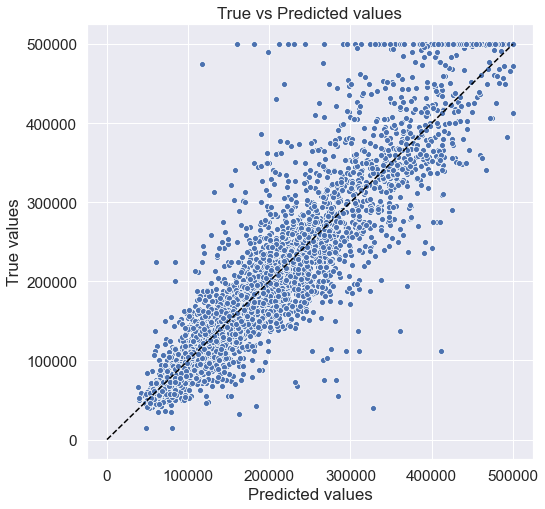

In [56]:
model = LGBMRegressor(max_depth=15, n_estimators=295, num_leaves=30, random_state=42)

model.fit(X_train, y_train)

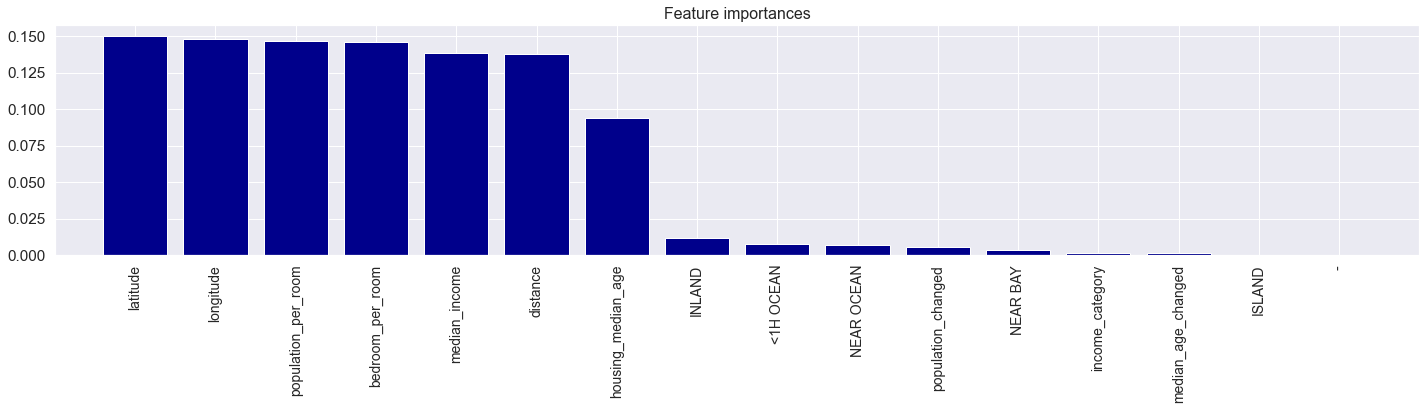

In [194]:
plot_feature_importances(importances = model.feature_importances_, X=X1)

## Учим финальную модель

In [195]:
model.fit(X1, y)

LGBMRegressor(max_depth=15, n_estimators=295, num_leaves=30, random_state=42)

In [196]:
y_pred = model.predict(X1_final)

for i in range(len(y_pred)):
    if y_pred[i] > 500000:
        y_pred[i] = 500001

In [197]:
y_pred_df = pd.DataFrame(y_pred, columns=['median_house_value'])

In [198]:
y_pred_df

,median_house_value
0,55669.265513
1,120516.804875
2,500001.000000
3,304513.895453
4,302265.649070
...,...
6807,182546.589128
6808,123836.219480
6809,128057.968635
6810,123473.437457


In [202]:
y_pred_df['median_house_value'].median()

186908.43113673633

In [203]:
X_final.index

Int64Index([20046,  3024, 15663, 20484,  9814, 13311,  7113,  7668, 18246,
             5723,
            ...
             6557,  3383, 16201, 18186,  3592, 15316, 14772, 12870, 13476,
            16123],
           dtype='int64', name='Id ', length=6812)

In [204]:
filename = '201120_Reznik_3.csv'
y_pred_df.to_csv(filename, index=None)